To change the pwd to the root directory of the repository so we can access the code directly by relatively referencing src and not needing to install sequence. 

In [1]:
cd ../..

/home/asingal/home/quisp/SeQUeNCe


/home/asingal/home/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


## Objective

The purpose of this notebook is to study the variation of time taken to generate 1000 entanglements in a Meet-in-the-Middle quantum repeater configurations against a varying placement of the Bell state measurement apparatus between the end nodes for a single memory. 

In [2]:
import numpy as np
import pandas as pd
import time
from matplotlib import pyplot as plt

from src.topology.router_net_topo import RouterNetTopo
from src.app.request_app import RequestApp
import src.utils.log as log

from datetime import date, datetime
today = date.today()

In [3]:
CONFIG_FILE = "example/SC24/config_files/simple_link.json"

# meta params
NO_TRIALS = 15
OUTPUT_FILE = f"results/variable_distance{str(today)}.csv"
LOGGING = False
LOG_OUTPUT = "results/var_mem_log.csv"
MODULE_TO_LOG = ["timeline", "memory", "bsm", "generation", "request_app", "optical_channel", "resource_manager"]


## Simulation paremeters

We consider the two communicating nodes to be 20 km apart from each other and the BSM is placed at a distance $d$ from one of the end nodes. The fibers have an attenuation of .2 dB/Km and the detectors are perfect threshold detectors. 

In [4]:
# simulation params
PREP_TIME = int(1e12)  # 1 second
COLLECT_TIME = int(2.5e12)  # 3.1, 10 seconds

# qc params
QC_FREQ = 1e11
total_distance = 20  # (unit: km)
distances = list(range(0,11))  # iterate through these (unit: km). distance of bsm from left. 

# application params
APP_NODE_NAME = "left"
OTHER_NODE_NAME = "right"
num_memo = 1

# storing data
data_dict = {"Distance": [],
             "Average Throughput": [],
             "Std. Throughput": [],
             "Average TTT": [],
             "Std. TTT":[],
             "probs":[]}

## Main simulation script

In [5]:
for i, distance in enumerate(distances):
    print(f"Running {NO_TRIALS} trials for distance {distance}km ({i + 1}/{len(distances)})")
    data_dict["Distance"].append(distance)
    throughputs = np.zeros(NO_TRIALS)
    time_to_thousand = np.zeros(NO_TRIALS)
    probs = np.zeros(NO_TRIALS)

    for trial_no in range(NO_TRIALS):
        # establish network
        net_topo = RouterNetTopo(CONFIG_FILE)

        # timeline setup
        tl = net_topo.get_timeline()
        tl.stop_time = PREP_TIME + COLLECT_TIME

        # Logging stuff
        if LOGGING:
            # set log
            if i == 3:
                log.set_logger(__name__, tl, LOG_OUTPUT)
                log.set_logger_level('WARN')
                for module in MODULE_TO_LOG:
                    log.track_module(module)
            elif i == 4:
                for module in MODULE_TO_LOG:
                    log.remove_module(module)

        # network configuration
        routers = net_topo.get_nodes_by_type(RouterNetTopo.QUANTUM_ROUTER)
        bsm_nodes = net_topo.get_nodes_by_type(RouterNetTopo.BSM_NODE)

        # Random seed for performing the simulations
        for j, node in enumerate(routers + bsm_nodes):
            node.set_seed(j + (trial_no * 3))

        # set quantum channel parameters. We also change the quantum channel dfistances to account for the 
        # variable placement of the BSm in the middle of the end nodes.
        left_distance = distance
        right_distance = total_distance - distance
        for qc in net_topo.get_qchannels():
            qc.frequency = QC_FREQ
            if qc.sender.name == APP_NODE_NAME:
                qc.distance = left_distance * 1e3
            elif qc.sender.name == OTHER_NODE_NAME:
                qc.distance = right_distance * 1e3
            else:
                raise Exception(f"Invalid sender node name '{qc.sender.name}'")
            
        # Since the BSM is placed at different distances from the end nodes, the classical channel delay also needs
        # to be altered.
        for cc in net_topo.get_cchannels():
            if cc.sender.name == bsm_nodes[0].name:
                if cc.receiver == APP_NODE_NAME:
                    cc.delay = left_distance * 1e3/cc.light_speed
                elif cc.receiver == OTHER_NODE_NAME:
                    cc.delay = right_distance * 1e3/cc.light_speed

            elif cc.receiver == bsm_nodes[0].name:
                if cc.sender.name == APP_NODE_NAME:
                    cc.delay = left_distance * 1e3/cc.light_speed
                elif cc.sender.name == OTHER_NODE_NAME:
                    cc.delay = right_distance * 1e3/cc.light_speed
                
        # establish "left" node as the start node. 
        start_node = None
        for node in routers:
            if node.name == APP_NODE_NAME:
                start_node = node
                break
        # Checking to see if the start node was established or not
        if not start_node:
            raise ValueError(f"Invalid app node name {APP_NODE_NAME}")
        
        # Setting the "right" node as the 'end' node
        end_node = None
        for node in routers:
            if node.name == OTHER_NODE_NAME:
                end_node = node
                break
        # Checking to see if the end node was established or not
        if not start_node:
            raise ValueError(f"Invalid other node name {OTHER_NODE_NAME}")

        # Establishing the apps on the start and end nodes. 
        app_start = RequestApp(start_node)
        app_end = RequestApp(end_node)

        # initialize and start app
        tl.init()
        app_start.start(OTHER_NODE_NAME, PREP_TIME, PREP_TIME + COLLECT_TIME, num_memo, 1.0)
        tl.run()

        # Used for debugging
        attempt = app_start.node.total_attempts
        success = app_start.node.succesful_attempts
        prob = success/attempt

        throughputs[trial_no] = app_start.get_throughput()
        time_to_thousand[trial_no] = app_start.node.time_to_thousand
        probs[trial_no] = prob
        print(f"\tCompleted trial {trial_no + 1}/{NO_TRIALS}")

    print("Finished trials.")

    # Saving the results in a dictionary to later convert into a Pandas data frame to plot. 

    avg_throughput = np.mean(throughputs)
    std_throughput = np.std(throughputs)
    avg_TTT = np.mean(time_to_thousand)
    std_TTT = np.std(time_to_thousand)
    avg_prob = np.mean(probs)

    # # Used for debugging
    # print(f"Average throughput: {avg_throughput} +/- {std_throughput}")
    # print(f"time to thousand entanglements:", time_to_thousand)

    data_dict["Average Throughput"].append(avg_throughput)
    data_dict["Std. Throughput"].append(std_throughput)
    data_dict["Average TTT"].append(avg_TTT/1e12)
    data_dict["Std. TTT"].append(std_TTT/1e12)
    data_dict["probs"].append(avg_prob)

df = pd.DataFrame(data_dict)

Running 15 trials for distance 0km (1/11)
	Completed trial 1/15
	Completed trial 2/15
	Completed trial 3/15
	Completed trial 4/15
	Completed trial 5/15
	Completed trial 6/15
	Completed trial 7/15
	Completed trial 8/15
	Completed trial 9/15
	Completed trial 10/15
	Completed trial 11/15
	Completed trial 12/15
	Completed trial 13/15
	Completed trial 14/15
	Completed trial 15/15
Finished trials.
Running 15 trials for distance 1km (2/11)
	Completed trial 1/15
	Completed trial 2/15
	Completed trial 3/15
	Completed trial 4/15
	Completed trial 5/15
	Completed trial 6/15
	Completed trial 7/15
	Completed trial 8/15
	Completed trial 9/15
	Completed trial 10/15
	Completed trial 11/15
	Completed trial 12/15
	Completed trial 13/15
	Completed trial 14/15
	Completed trial 15/15
Finished trials.
Running 15 trials for distance 2km (3/11)
	Completed trial 1/15
	Completed trial 2/15
	Completed trial 3/15
	Completed trial 4/15
	Completed trial 5/15
	Completed trial 6/15
	Completed trial 7/15
	Completed tri

## Results

We see that the amount of time taken to generate 1000 entanglements remains constant as we move the BSM between the two end nodes. This aligns well with theoretical expectations since moving the BSM does not changwe the overall attenuation in the system, thereby rendering the overall BSM probability to not depend on the placement of the BSM. Theoretically, $TTT = 4L/c$

,Distance,Average Throughput,Std. Throughput,Average TTT,Std. TTT,probs
0,0,492.026667,11.004452,2.030827,0.050464,0.196842
1,1,501.546667,10.439787,1.987547,0.045469,0.200651
2,2,503.386667,9.355631,1.979413,0.045214,0.201387
3,3,496.586667,9.851015,2.007040,0.048747,0.198666
4,4,495.253333,15.258041,2.010400,0.065861,0.198133
5,5,496.506667,13.290973,2.020933,0.070865,0.198634
6,6,491.546667,12.370172,2.029493,0.048632,0.196650
7,7,497.466667,12.425064,2.008907,0.052047,0.199019
8,8,500.213333,14.656869,1.992560,0.067774,0.200117
9,9,494.320000,8.832908,2.017760,0.045121,0.197760


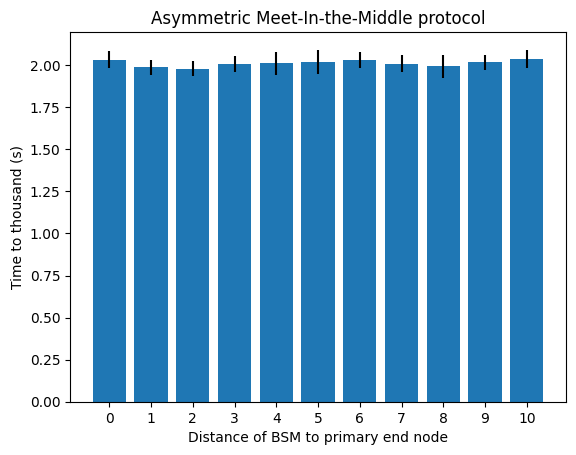

In [6]:
plt.bar(range(len(df["Average TTT"])), df["Average TTT"], yerr = df["Std. TTT"], tick_label = df["Distance"])
plt.ylabel("Time to thousand (s)")
plt.xlabel("Distance of BSM to primary end node")
plt.title("Asymmetric Meet-In-the-Middle protocol")
df